# Clasificador de venta de tarjetas de crédito

El objetivo de este proyecto es desarrollar y poner en producción un modelo de clasificación que busca identificar a los posibles individuos (prospectos de acá en adelante) que más probabilidad tienen de aceptar el producto tarjeta de crédito (TC) ante una campaña dirigida de llamadas salientes por parte de la red de sucursales de una entidad bancaria. De esta forma esperamos poder llevar adelante campañas de venta más asertivas y a su vez, en caso de necesidad (como puede ser el cumplimiento del plan comercial), hacer pre-embozados (imprimir tarjeta antes de concretar venta) y enviarlos al domicilio asegurándose una alta tasa de aceptación del plástico (venta).

## Importamos librerías

In [101]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline, make_union
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
from sklearn.metrics import classification_report
import pickle
import os

## Data set

El dataset con el que trabajaremos contiene información socioeconómica, de bancarización y el resultado de la gestión de los 28.867 prospectos que fueron precalificados y gestionados, a través de llamadas salientes, para la venta de una TC. Los features con los que cuenta el dataset son los siguientes:
- Venta: 1 indica venta del producto y 0 el rechazo. Es nuestra variable target.
- OFERTA_TC_AJUSTADA: margen crediticio ofrecido.
- NSE: nivel socioeconómico. Puede asumir los valores D1, C3, C2, C1, B, A (de menor a mayor respectivamente).
- Actividad: categoría laboral según facturación anual. Las categorías pueden ser: monotributista, autónomo, informal (no registrado) o pasivo (jubilado).
- CatMonotributo: categoría de monotributo, en caso de corresponder. Van desde la A a la K (de menor a mayor ingreso bruto).
- EDAD.
- Sexo.
- Localidad: de residencia.
- Es Empleador.
- Es Empleado.
- EsJubilado.
- Banco_N_1: indica cual es la principal entidad financiera con la que tiene deuda vigente. 
- Cant_bcos: cantidad de entidades financieras con las que tiene deuda vigente en algún producto activo como TC o préstamo.
- Monto_bcos: monto adeudado a todas las entidades financieras con las que tiene deuda vigente.


 Hablar de deuda no significa mora o no pago, simplemente un crédito a favor de la entidad financiera.

In [103]:
# Importamos data set:

df = pd.read_csv('base_MA_final.csv',sep=';')
display(df.head(5))

print(f'Cantidad de registros: {df.shape[0]}.')
print(f'Cantidad de variables: {df.shape[1]}.')

,ID,Venta,OFERTA_TC_AJUSTADA,NSE,Actividad,CatMonotributo,EDAD,Sexo,Localidad,EsEmpleador,EsEmpleado,EsJubilado,Banco_N_1,Cant_Bcos,Monto_Bcos
0,1,0,159200,B,Monotributista,H - Locaciones de Servicios,72,M,Morterosa,NaN,NaN,Si,Tarj Naranja,1,10000
1,2,0,45500,C1,Monotributista,H - Locaciones de Servicios,72,M,Las Varillasa,NaN,NaN,Si,NaN,0,0
2,3,0,45500,C2,Monotributista,B - Ventas de Cosas Muebles,72,M,Rio Terceroa,NaN,NaN,Si,NaN,0,0
3,4,0,34300,C2,Monotributista,A - Ventas de Cosas Muebles,72,M,Bell Ville,NaN,NaN,Si,NaN,0,0
4,5,0,45500,C1,Monotributista,E - Locaciones de Servicios,71,M,Malaguenoa,Si,NaN,Si,NaN,0,0


Cantidad de registros: 28867.
Cantidad de variables: 15.


In [104]:
# Dropeamos la columnas que no utilizaremos en nuestros modelos:
df = df.drop(['ID','EsEmpleado','EsEmpleador','EsJubilado','Localidad'],axis=1)
df.columns

Index(['Venta', 'OFERTA_TC_AJUSTADA', 'NSE', 'Actividad', 'CatMonotributo',
       'EDAD', 'Sexo', 'Banco_N_1', 'Cant_Bcos', 'Monto_Bcos'],
      dtype='object')

In [105]:
# Renombramos columnas:

df = df.rename(columns=
               {
                'OFERTA_TC_AJUSTADA'                : 'Oferta',
                'CatMonotributo'                    : 'Cat_mono',
                'EDAD'                              : 'Edad',
                'Banco_N_1'                         : 'Banco_1', 
                'Sexo'                              : 'Masculino'                         
                })
df.columns

Index(['Venta', 'Oferta', 'NSE', 'Actividad', 'Cat_mono', 'Edad', 'Masculino',
       'Banco_1', 'Cant_Bcos', 'Monto_Bcos'],
      dtype='object')

In [106]:
# Inspeccionamos base:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28867 entries, 0 to 28866
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Venta       28867 non-null  int64 
 1   Oferta      28867 non-null  int64 
 2   NSE         28867 non-null  object
 3   Actividad   28867 non-null  object
 4   Cat_mono    13119 non-null  object
 5   Edad        28867 non-null  int64 
 6   Masculino   28844 non-null  object
 7   Banco_1     16090 non-null  object
 8   Cant_Bcos   28867 non-null  int64 
 9   Monto_Bcos  28867 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 2.2+ MB


In [107]:
# Estadística descriptiva:
df.describe().round(2)

,Venta,Oferta,Edad,Cant_Bcos,Monto_Bcos
count,28867.00,28867.00,28867.0,28867.00,28867.00
mean,0.55,75245.63,45.7,0.61,32733.16
std,0.50,55320.37,11.7,0.58,66188.97
min,0.00,25900.00,21.0,0.00,0.00
25%,0.00,45500.00,36.0,0.00,0.00
50%,1.00,45500.00,45.0,1.00,6000.00
75%,1.00,89100.00,55.0,1.00,40000.00
max,1.00,299300.00,81.0,3.00,1551000.00


## Preparación de los datos y creación de clases para pipeline

### Tratamiento variables monetarias

In [110]:
# Dado el contexto inflacionario de Argentina, lo más conveniente es "atar" las variables a algún valor, nosotros lo ataremos al Salario Mínimo Vital y Móvil:

class SMVM(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            SMVM = 27216
            X[self.columns] = pd.DataFrame(X[self.columns]) / SMVM
            return X[self.columns]
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self

In [111]:
cs = SMVM(['Oferta','Monto_Bcos'])

cs.transform(df).head()

,Oferta,Monto_Bcos
0,5.849500,0.367431
1,1.671811,0.000000
2,1.671811,0.000000
3,1.260288,0.000000
4,1.671811,0.000000


### Variables categóricas a numéricas

In [115]:
# Convertimos la variable sexo en una dummy, siendo 1 masculino:

class GenderDummy(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            
            return pd.DataFrame(X[self.columns].replace(to_replace={'M': 1, 'F': 0}, inplace=True))
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self

In [116]:
sex = GenderDummy('Masculino')
sex.fit_transform(df)
sex

GenderDummy(columns='Masculino')

### Variables ordinales

In [117]:
# Convertimos al NSE en variable ordinal indicando con el valor más alto, el NSE más alto.

class Ordinales(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            
            return pd.DataFrame(X[self.columns].replace(to_replace={'A': 6, 'B': 5, 'C1': 4, 'C2': 3, 'C3': 2, 'D1': 1}, inplace=True))
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self    

In [118]:
SL=Ordinales('NSE')
SL.fit_transform(df)
SL

Ordinales(columns='NSE')

### Tratamiento de valores faltantes

In [119]:
# En el caso de Banco_1 los valores faltantes no son por falta de información o error de carga, sino que denotan el caso negativo de la variable en cuestión, es decir,
# no tienen deuda vigente con ninguna entidad financiera. Es por esta razón que reemplazaremos los NaN con 0.
df.Banco_1.replace(to_replace={np.NaN: '0'}, inplace=True)

In [120]:
# En el caso de Cat_mono los valores faltantes aparecen en los casos en que la Actividad no es Monotributista, por lo que reemplazaremos los NaN con vacios.
df.Cat_mono.replace(to_replace={np.NaN: '.'}, inplace=True)

### Concatenar features

In [121]:
# Concatenamos las featuers Actividad y Cat_mono ya que son complementarias y nos conviene trabajarlas de esta forma:
df['Act'] = df['Actividad'] + ' ' + df['Cat_mono'].str[0]
df['Act'].value_counts()

Empleado .          9682
Monotributista B    4154
Autonomo .          3608
Informal .          2458
Monotributista D    2223
Monotributista A    1905
Monotributista C    1824
Monotributista E    1097
Monotributista F     732
Monotributista G     553
Monotributista H     548
Monotributista I      42
Monotributista J      26
Monotributista K      15
Name: Act, dtype: int64

### Agrupación de datos

In [122]:
# Vemos que un alto porcentaje de los prospectos se concentra en pocas entidades o en ninguna (0 entidades):
part_bcos = df.Banco_1.value_counts(normalize=True)
#print(part_bcos)

princ_bcos = part_bcos.iloc[:5].index

print(f'El {((part_bcos.iloc[:5].values.sum())*100).round()}% de los prospectos están concentrandos en las siguientes 5 entidades: \n {princ_bcos.values}')

El 86.0% de los prospectos están concentrandos en las siguientes 5 entidades: 
 ['0' 'Tarj Naranja' 'Bco Macro' 'Bco Santander Río' 'Bco Galicia']


In [123]:
ef = df.Banco_1.unique()

print(f'El {(100-((part_bcos.iloc[:5].values.sum()))*100).round()}% de los prospectos tiene deuda vigente en {(ef.shape[0])-5} entidades.')

El 14.0% de los prospectos tiene deuda vigente en 86 entidades.


In [124]:
# Por lo tanto, procedemos a agrupar estas 86 entidades en 'Otros':
df['Banco_1'] = df['Banco_1'].apply(lambda x: 'Otros' if x not in princ_bcos else x)

In [24]:
# Verificamos:
df.Banco_1.value_counts(normalize=True)

0                    0.442616
Tarj Naranja         0.262376
Otros                0.139017
Bco Macro            0.070704
Bco Santander Río    0.053175
Bco Galicia          0.032113
Name: Banco_1, dtype: float64

### Dummies

In [125]:
# Chequeamos variables, vemos si tenemos datos nulos y transformamos a dummies las categóricas.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28867 entries, 0 to 28866
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Venta       28867 non-null  int64  
 1   Oferta      28867 non-null  float64
 2   NSE         28867 non-null  int64  
 3   Actividad   28867 non-null  object 
 4   Cat_mono    28867 non-null  object 
 5   Edad        28867 non-null  int64  
 6   Masculino   28844 non-null  float64
 7   Banco_1     28867 non-null  object 
 8   Cant_Bcos   28867 non-null  int64  
 9   Monto_Bcos  28867 non-null  float64
 10  Act         28867 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 2.4+ MB


In [128]:
# Clase para variables convertir variables categóricas a dummies:

class CategoricaDummy(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.ft = None
        self.enc = None
    
    def fit(self, X, *_):
        if isinstance(X, pd.DataFrame):
            enc = OneHotEncoder()
            #self.cat = X[self.columns]
            self.ft = enc.fit(X[self.columns])
            return self.ft
        
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
            
    def transform(self, X, *_):
        dummies = self.ft.transform(X[self.columns]).toarray()
        return dummies, self.ft

In [129]:
category=CategoricaDummy(['Act', 'Banco_1'])
category.fit(df)
dummies, ft = category.transform(df)

In [130]:
pasos = [('Oferta', cs),
         ('Masc', sex), 
         ('NSE', SL),
         ('categoria', category)]


pipe=Pipeline(pasos)

In [131]:
pipe

Pipeline(steps=[('Oferta', SMVM(columns=['Oferta', 'Monto_Bcos'])),
                ('Masc', GenderDummy(columns='Masculino')),
                ('NSE', Ordinales(columns='NSE')),
                ('categoria', CategoricaDummy(columns=['Act', 'Banco_1']))])

In [132]:
ft.categories_

[array(['Autonomo .', 'Empleado .', 'Informal .', 'Monotributista A',
        'Monotributista B', 'Monotributista C', 'Monotributista D',
        'Monotributista E', 'Monotributista F', 'Monotributista G',
        'Monotributista H', 'Monotributista I', 'Monotributista J',
        'Monotributista K'], dtype=object),
 array(['0', 'Bco Galicia', 'Bco Macro', 'Bco Santander Río', 'Otros',
        'Tarj Naranja'], dtype=object)]

In [133]:
dummies_df = pd.DataFrame(dummies)
dummies_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28862,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
28863,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
28864,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
28865,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [134]:
categoricals = ['Act','Banco_1']

In [135]:
# Renombramos las variables:
col_names = [ft.categories_[i] for i in range(len(categoricals))]
col_names

# Convertimos a lista:
col_names_list = [sublist[i] for sublist in col_names for i in range(len(sublist))]

In [136]:
col_names_list

['Autonomo .',
 'Empleado .',
 'Informal .',
 'Monotributista A',
 'Monotributista B',
 'Monotributista C',
 'Monotributista D',
 'Monotributista E',
 'Monotributista F',
 'Monotributista G',
 'Monotributista H',
 'Monotributista I',
 'Monotributista J',
 'Monotributista K',
 '0',
 'Bco Galicia',
 'Bco Macro',
 'Bco Santander Río',
 'Otros',
 'Tarj Naranja']

In [137]:
#Asignamos los nombres de las columnas al data frame:
dummies_df.columns = col_names_list
dummies_df.head(3)

,Autonomo .,Empleado .,Informal .,Monotributista A,Monotributista B,Monotributista C,Monotributista D,Monotributista E,Monotributista F,Monotributista G,Monotributista H,Monotributista I,Monotributista J,Monotributista K,0,Bco Galicia,Bco Macro,Bco Santander Río,Otros,Tarj Naranja
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [138]:
print(dummies_df.shape)
print(df.shape)

(28867, 20)
(28867, 11)


In [139]:
# Unimos los dataframes:
df1 = pd.concat([df, dummies_df], axis=1)
display(df1.head())
df1.shape

,Venta,Oferta,NSE,Actividad,Cat_mono,Edad,Masculino,Banco_1,Cant_Bcos,Monto_Bcos,...,Monotributista H,Monotributista I,Monotributista J,Monotributista K,0,Bco Galicia,Bco Macro,Bco Santander Río,Otros,Tarj Naranja
0,0,5.849500,5,Monotributista,H - Locaciones de Servicios,72,1.0,Tarj Naranja,1,0.367431,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,1.671811,4,Monotributista,H - Locaciones de Servicios,72,1.0,0,0,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,1.671811,3,Monotributista,B - Ventas de Cosas Muebles,72,1.0,0,0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,1.260288,3,Monotributista,A - Ventas de Cosas Muebles,72,1.0,0,0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,1.671811,4,Monotributista,E - Locaciones de Servicios,71,1.0,0,0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


(28867, 31)

In [140]:
# Validamos si está bien realizada la concatenación de los data frames y la dummización:
df1.loc[:,['Actividad','Autonomo .','Empleado .','Monotributista A','Informal .']].sample(5)

,Actividad,Autonomo .,Empleado .,Monotributista A,Informal .
18685,Monotributista,0.0,0.0,0.0,0.0
9791,Empleado,0.0,1.0,0.0,0.0
9164,Empleado,0.0,1.0,0.0,0.0
19364,Autonomo,1.0,0.0,0.0,0.0
24928,Monotributista,0.0,0.0,1.0,0.0


In [141]:
# Dropeamos las variables categóricas que transformamos a dummies, las dummies "Informal" y "0" ("Banco_1") para evitar problemas de multicolinealidad.

df2 = df1.drop(['Actividad','Cat_mono','Banco_1','Informal .','0','Act'], axis=1)
print(df2.shape)
print(df2.columns)

(28867, 25)
Index(['Venta', 'Oferta', 'NSE', 'Edad', 'Masculino', 'Cant_Bcos',
       'Monto_Bcos', 'Autonomo .', 'Empleado .', 'Monotributista A',
       'Monotributista B', 'Monotributista C', 'Monotributista D',
       'Monotributista E', 'Monotributista F', 'Monotributista G',
       'Monotributista H', 'Monotributista I', 'Monotributista J',
       'Monotributista K', 'Bco Galicia', 'Bco Macro', 'Bco Santander Río',
       'Otros', 'Tarj Naranja'],
      dtype='object')


In [142]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28867 entries, 0 to 28866
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Venta              28867 non-null  int64  
 1   Oferta             28867 non-null  float64
 2   NSE                28867 non-null  int64  
 3   Edad               28867 non-null  int64  
 4   Masculino          28844 non-null  float64
 5   Cant_Bcos          28867 non-null  int64  
 6   Monto_Bcos         28867 non-null  float64
 7   Autonomo .         28867 non-null  float64
 8   Empleado .         28867 non-null  float64
 9   Monotributista A   28867 non-null  float64
 10  Monotributista B   28867 non-null  float64
 11  Monotributista C   28867 non-null  float64
 12  Monotributista D   28867 non-null  float64
 13  Monotributista E   28867 non-null  float64
 14  Monotributista F   28867 non-null  float64
 15  Monotributista G   28867 non-null  float64
 16  Monotributista H   288

In [145]:
# Como tenemos valores faltantes en sexo, dropeamos esos casos:
print(f"Casos a dropear: {df2.Masculino.isnull().sum()}.")

Casos a dropear: 23.


In [146]:
df3 = df2.dropna(axis=0,subset = ['Masculino'])
df3.shape

(28844, 25)

In [147]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28844 entries, 0 to 28866
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Venta              28844 non-null  int64  
 1   Oferta             28844 non-null  float64
 2   NSE                28844 non-null  int64  
 3   Edad               28844 non-null  int64  
 4   Masculino          28844 non-null  float64
 5   Cant_Bcos          28844 non-null  int64  
 6   Monto_Bcos         28844 non-null  float64
 7   Autonomo .         28844 non-null  float64
 8   Empleado .         28844 non-null  float64
 9   Monotributista A   28844 non-null  float64
 10  Monotributista B   28844 non-null  float64
 11  Monotributista C   28844 non-null  float64
 12  Monotributista D   28844 non-null  float64
 13  Monotributista E   28844 non-null  float64
 14  Monotributista F   28844 non-null  float64
 15  Monotributista G   28844 non-null  float64
 16  Monotributista H   288

In [148]:
df3.head()

,Venta,Oferta,NSE,Edad,Masculino,Cant_Bcos,Monto_Bcos,Autonomo .,Empleado .,Monotributista A,...,Monotributista G,Monotributista H,Monotributista I,Monotributista J,Monotributista K,Bco Galicia,Bco Macro,Bco Santander Río,Otros,Tarj Naranja
0,0,5.849500,5,72,1.0,1,0.367431,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,1.671811,4,72,1.0,0,0.000000,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.671811,3,72,1.0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1.260288,3,72,1.0,0,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1.671811,4,71,1.0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### EDA

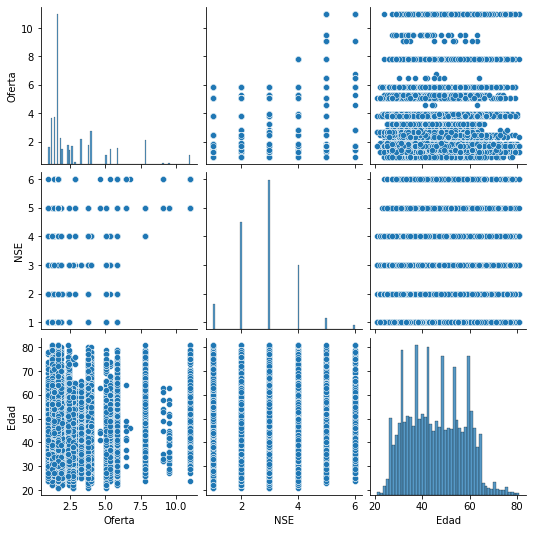

In [149]:
# Realizamos un pair plot de las variables con las características de los prospectos contactados. Podemos observar que hay un amplio rango de edades y NSE. La base de 
# datos es heterogénea.

sns.pairplot(data = df3, vars=['Oferta','NSE', 'Edad'])
plt.show()

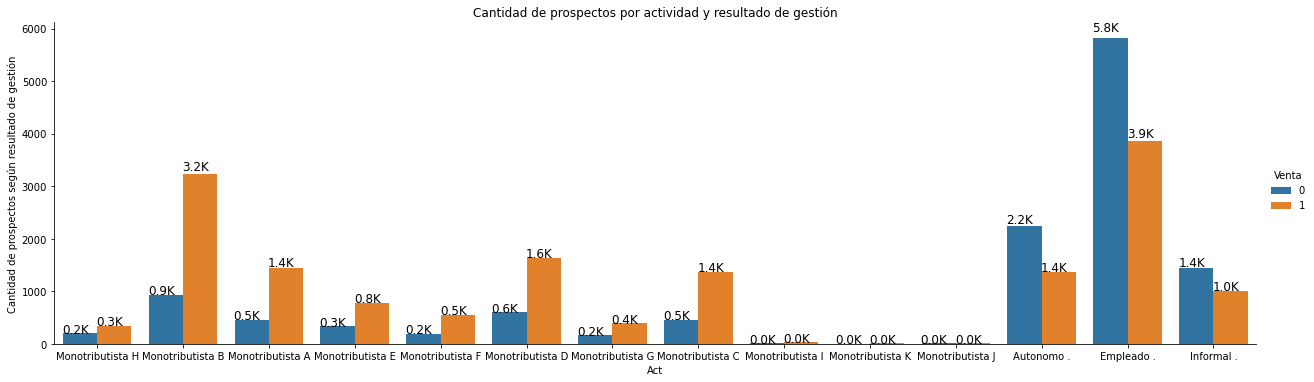

In [150]:
# Analizamos la aceptación del producto en relación a la actividad de los prospectos.
# El segmento con mayor tasa de aceptación que de rechazo es el de monotributistas en todas sus categorías.

vta_act = sns.catplot(data=df1, x = 'Act', aspect=3.5, kind='count', hue='Venta')
vta_act.set_ylabels('Cantidad de prospectos según resultado de gestión')
vta_act.ax.set_title('Cantidad de prospectos por actividad y resultado de gestión')

ax = vta_act.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{0:.1f}K'.format(p.get_height()/1000),   
            color='black', 
            rotation='horizontal', 
            size='large')

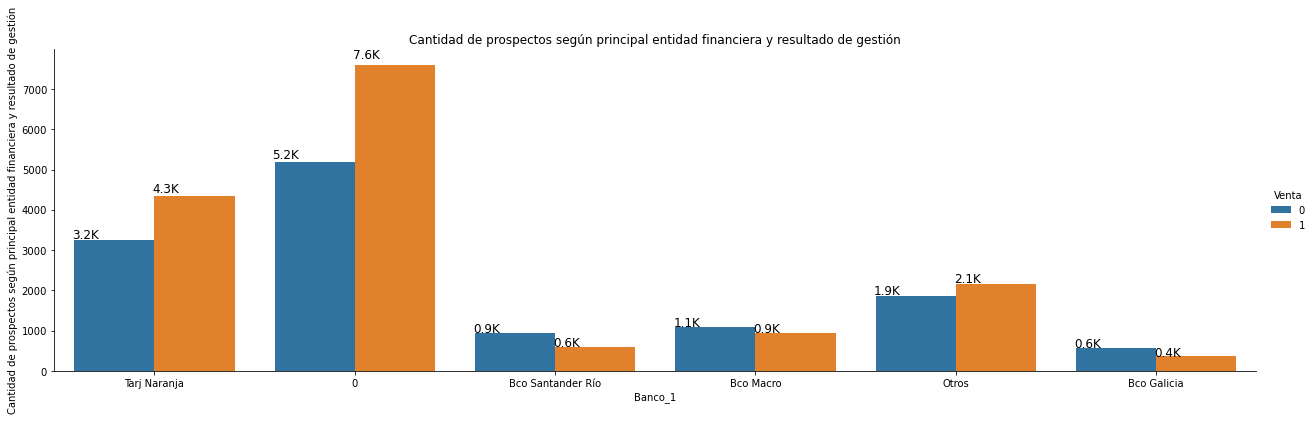

In [151]:
# Analizamos la aceptación del producto en relación a la principal entidaad del prospecto.
# La mayor tasa de aceptación respecto a la de rechazos se dan en individuos que no poseen deuda con otras entidades, seguidos por los clientes de Naranja y otras 
# entidades (con baja participación en la prospección actual).

vta_ef = sns.catplot(data=df1, x = 'Banco_1', aspect=3.5, kind='count', hue='Venta')
vta_ef.set_ylabels('Cantidad de prospectos según principal entidad financiera y resultado de gestión')
vta_ef.ax.set_title('Cantidad de prospectos según principal entidad financiera y resultado de gestión')

ax = vta_ef.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{0:.1f}K'.format(p.get_height()/1000),   
            color='black', 
            rotation='horizontal', 
            size='large')

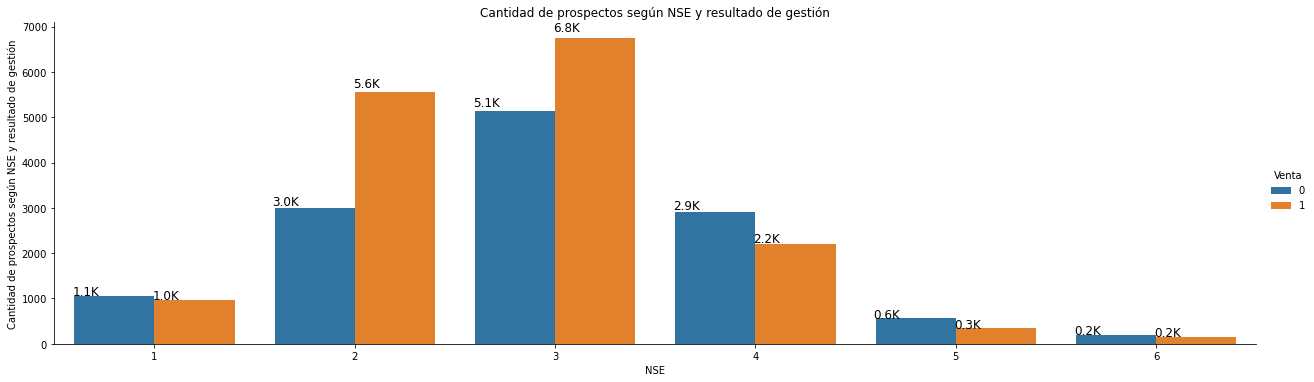

In [152]:
# Analizamos la aceptación del producto en relación a la principal entidaad del prospecto.
# La mayor tasa de aceptación respecto a la de rechazos se dan en individuos que no poseen deuda con otras entidades, seguidos por los clientes de Naranja y otras 
# entidades (con baja participación en la prospección actual).

vta_NSE = sns.catplot(data=df1, x = 'NSE', aspect=3.5, kind='count', hue='Venta')
vta_NSE.set_ylabels('Cantidad de prospectos según NSE y resultado de gestión')
vta_NSE.ax.set_title('Cantidad de prospectos según NSE y resultado de gestión')

ax = vta_NSE.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{0:.1f}K'.format(p.get_height()/1000),   
            color='black', 
            rotation='horizontal', 
            size='large')

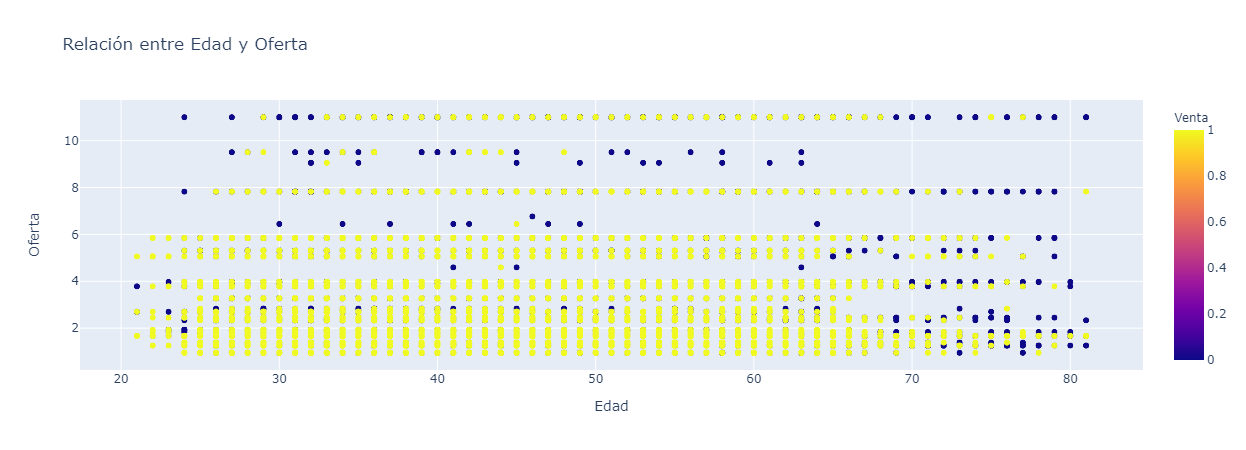

In [153]:
# Relacionamos las variables Edad y Oferta, observando como la no aceptación del producto se acentua en personas de +70 años o en donde la Oferta es elevada 
# (lo cual es producto de buen score, por lo que probablemente el prospecto se encuentre bancarizado por otra entidad y con un buen comportamiento).

fig = px.scatter(df3, x = 'Edad', y = 'Oferta', color = df3.Venta, title = 'Relación entre Edad y Oferta')
fig.show()

#### Correlaciones

Text(0.5, 1.0, 'Matriz de correlaciones entre variables')

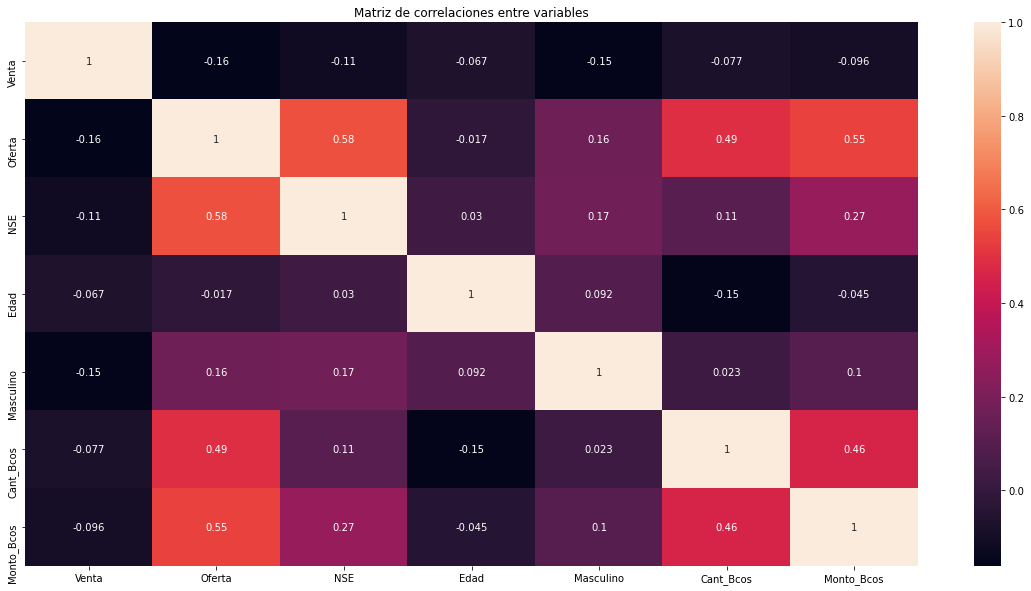

In [154]:
# Graficamos correlaciones sobre base inicial:

f, ax =plt.subplots(figsize =(20,10))
sns.heatmap(df.corr(), annot = True)
plt.title("Matriz de correlaciones entre variables")

Text(0.5, 1.0, 'Matriz de correlaciones con el target')

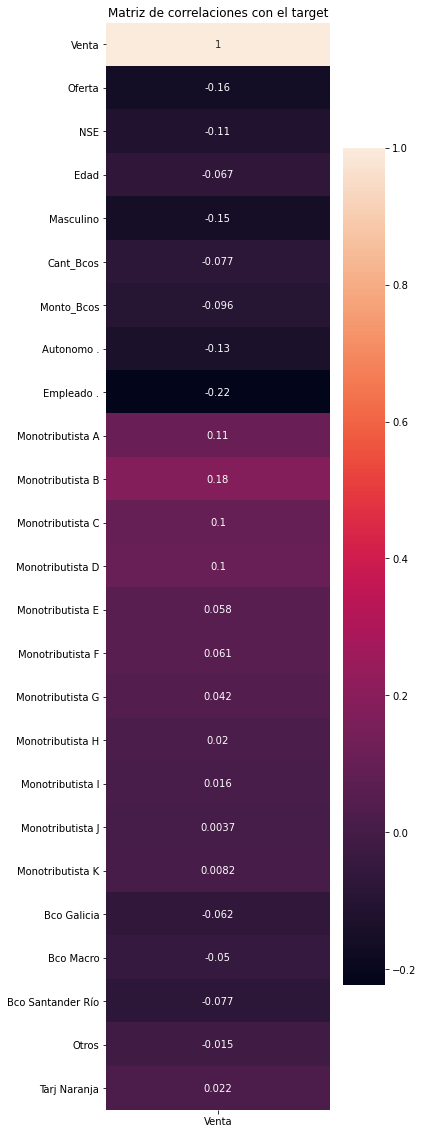

In [155]:
# Graficamos correlaciones de todas las variables respecto a la variable target ("Venta"):

plt.figure(figsize=(5,20))
sns.heatmap(df3.corr()[['Venta']], annot=True)
plt.title("Matriz de correlaciones con el target")

### Train-Test split

In [156]:
# Antes de splitear revisamos si el data set está balanceado:
df3.Venta.value_counts(normalize=True).round(2)

1    0.55
0    0.45
Name: Venta, dtype: float64

In [54]:
# El data set está muy balanceado, igualmente se realizará estratificación en todos los casos. 

In [157]:
# Preparamos la matriz de features y el vector objetivo:
X = df3.drop(columns=['Venta'])
y = df3['Venta']

X.shape, y.shape

((28844, 24), (28844,))

In [158]:
# Separamos el data set de modelado en train y test:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0)

# Verificamos que coincidan las proporciones del target:
print(y_train.mean().round(2), y_test.mean().round(2))

0.55 0.55


#### Preparación de los datos

Estandarizamos los datos para la regularización del modelo.

Para la implementación de la regresión logística se aplica regularización por defecto con el hiperparámetro C, por lo que es de suma importancia estandarizar los datos antes de fitear el modelo.

In [159]:
# Utilizamos la función StandarScaler() la cual a cada valor le resta su media y lo divide por su varianza:

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

## Modelización

### Baseline

Para el Baseline vamos a utilizar al clasificador DummyClassifier, el cual realiza predicciones con reglas muy sencillas. 

Este clasificador es muy útil para tener un base simple para comparar con otros modelos de clasificación más complejos.

#### Ajuste del modelo

In [160]:
# Los argumentos que usaremos son:
#  - strategy = "stratified": genera predicciones respetando la distribución de las clases del set de entrenamiento.
#  - random_state = 0: controla la aleatoriedad de las predicciones.

dummy_clf = DummyClassifier(strategy = "stratified", random_state = 0)
dummy_clf.fit(X_train_std, y_train)

DummyClassifier(random_state=0, strategy='stratified')

### KNN

KNN se encarga de memorizar la ubicación de cada muestra del conjunto de entrenamiento de acuerdo a los valores de sus features y cuando recibe un dato nuevo, lo ubica en la posición del espacio que le corresponde según sus características y encuentra los k vecinos más cercanos (k es un hiperparámetro del modelo que define cuántos vecinos se van a considerar al momento de hacer las predicciones). Estos vecinos son las muestras del conjunto de entrenamiento que resultan más similares a la observación que queremos clasificar. Una vez que se identificaron los k vecinos más cercanos, cada uno de ellos aporta un "voto" a la clase a la que corresponde. La predicción queda determinada por la clase mayoritaria entre los k vecinos más cercanos.

#### Ajuste del modelo

In [161]:
# Los argumentos que utilizaremos en este modelo son:
#  - metric = 'manhattan': la distancia entre dos puntos se calcula como la suma de las diferencias absolutas de sus coordenadas.
#  - n_neighbors = 5: este hiperparámetro está seteado por default en 5 vecinos.

knn = KNeighborsClassifier(metric='manhattan')
# Ajustamos a los datos de entrenamiento:
knn.fit(X_train_std, y_train)

KNeighborsClassifier(metric='manhattan')

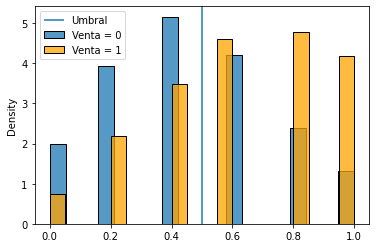

In [162]:
# Histograma de probabilidades:
sns.histplot(data = knn.predict_proba(X_test_std[y_test==0])[:,1], stat = 'density')
sns.histplot(data = knn.predict_proba(X_test_std[y_test==1])[:,1], stat = 'density', color = 'orange')
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'Venta = 0', 'Venta = 1'])

### Regresión logística:

La regresión logística es uno de los tantos modelos que se utilizan para estimar el valor de una variable categórica, es decir, las predicciones obtenidas son las clases de pertenencia de cada observación según el modelo. El modelo estima las probabilidades de pertenecer a cada clase y compara esas probabilidades con un umbral.
De esta manera se logra clasificar a las observaciones en función de las probabilidades de que pertenezca a una clase. Para visualizar estas probabilidades usamos el método '.predict_proba()'.

Scikit-Learn utiliza el método de máxima verosimilitud, acercando las predicciones a los valores reales de las observaciones.

El hiperparámetro más relevante de este modelo es el de la función de costo, el cual puede ser modificado para reducir el sobreajuste agregando un término de regularización. Scikit-Learn hace esto por defecto con el hiperparámetro C.

#### Ajuste del modelo

In [163]:
# Ajustamos el modelo tomando en cuenta los siguientes argumentos:
#  - max_iter = 1000: imponemos un número máximo de iteraciones para que funcione correctamente para encontrar el mejor ajuste.
#  - class_weight ='balanced': el peso está asociado con las clases, si no se lo dieramos se supondría que todas las clases tienen el mismo peso (igual a 1).
#  - C = 1 por default: es la inversa del factor de regularización, asume un valor posit]ivo (jugaremos con él más adelante cuando apliquemos grid y random search para 
#    encontrar el mejor hiperparámetro). Mientras mas bajo el valor, más fuerte será la regularización.

lr = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
lr.fit(X_train_std, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

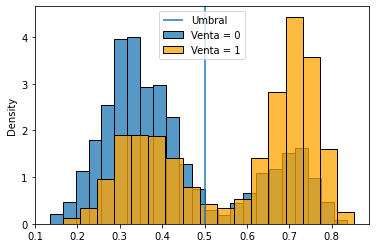

In [164]:
# Histograma de probabilidades:
sns.histplot(data = lr.predict_proba(X_test_std[y_test==0])[:,1], stat = 'density')
sns.histplot(data = lr.predict_proba(X_test_std[y_test==1])[:,1], stat = 'density', color = 'orange')
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'Venta = 0', 'Venta = 1'])

### Naive Bayes

El teorema de Bayes es una fórmula matemática utilizada para determinar la probabilidad condicional. La probabilidad condicional es la probabilidad de que ocurra un resultado, basada en la existencia de un resultado anterior. Por lo tanto lo que hace el teorema de Bayes es proporcionar una forma de revisar las predicciones o teorías existentes (actualización de probabilidades) a la luz de evidencia nueva o adicional. 

El modelo de Naive Bayes es una familia de clasificadores basados en la aplicación del Teorema de Bayes. Este algoritmo supone que todas las features en el conjunto de datos no están correlacionadas entre sí, de ahí el término "naive". Naive Bayes es el algoritmo más simple que podemos aplicar a nuestros datos y se utiliza principalmente para obtener la precisión base del dataset.

Los distintos algoritmos de Naive Bayes difieren en la distribución que suponen para $P(x_i|y)$:

* Gaussian: supone distribución Gaussiana multidimensional.

* Multinomial: supone distribución multinomial. 

* Bernoulli: supone distribución bernoulli multivariada (puede haber múltiples features, pero se supone que cada una es una variable de valor binario (Bernoulli, booleana)).

#### Ajuste del modelo

Utilizaremos el clasificador Naive Bayes Gaussiano ya que suponemos que los datos de cada etiqueta se extraen de una distribución gaussiana multivariada donde las features son independientes entre sí.

In [165]:
# Construimos una instancia del clasificador y entrenamos el modelo:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

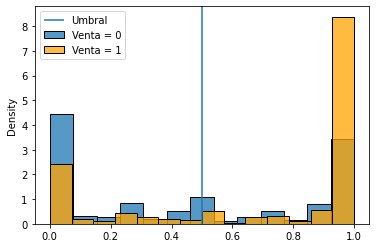

In [166]:
# Histograma de probabilidades:
sns.histplot(data = gnb.predict_proba(X_test_std[y_test==0])[:,1], stat = 'density')
sns.histplot(data = gnb.predict_proba(X_test_std[y_test==1])[:,1], stat = 'density', color = 'orange')
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'Venta = 0', 'Venta = 1'])

## Evaluación de modelos y tuneo de hiperparámetros

### F1-Score

Es un promedio armónico entre precision y recall.

Precision o positive predictive value (PPV) mide qué tan "preciso" es el clasificador al predecir las instancias positivas, es decir, cuán frecuente es correcta la predicción realizada cuando predice un valor positivo. Se calcula como el número de predicciones correctas sobre el número total de predicciones. Esta métrica nos permite evaluar el peso de los Falsos Positivos (FP).

Recall, Sensitivity o True Positive Rate (TPR) mide la capacidad (qué tan "sensible" es) del modelo de detectar los Verdaderos Positivos (TP) sobre todos los casos que son positivos. En nuestro caso, del total de ventas, sería evaluar cuántas ventas logra identificar correctamente el modelo.

La ventaja de usar la media armónica, es que el resultado del F1-Score no es sensible a valores altos de una de las dos variables (recall o precision). Por otro lado, no todos los valores extremos son ignorados, ya que los que son muy bajos si tienen peso en el resultado final.

Es decir que para tener un F1-Score alto, es necesario que tanto el recall como la precision sean altas, mientras que un F1-Score bajo puede ser el resultado de un valor bajo en por lo menos una de estas métricas o en ambas a la vez.

Como nuestro problema es de class label, decidimos utilizar esta métrica para la evaluación de la performance de los diferentes modelos.

In [201]:
# Para calcular las métricas para evaluar nuestros modelos utilizamos el data set que separamos en un comienzo y no hemos utilizado aún para entrenar o testear:

y_pred_baseline = dummy_clf.predict(X_test_std)
y_pred_knn = knn.predict(X_test_std)
y_pred_lr = lr.predict(X_test_std)
y_pred_gnb = gnb.predict(X_test)

print(f'F1-Score de los diferentes modelos:')
print()
print(f'Baseline:{f1_score(y_test, y_pred_baseline).round(4)}.')
print(f'KNN:{f1_score(y_test, y_pred_knn).round(4)}.')
print(f'Regresión logística: {f1_score(y_test, y_pred_lr).round(4)}.')
print(f'Naive Bayes Gaussiano sin Estandarizar: {f1_score(y_test, y_pred_gnb).round(4)}.')

F1-Score de los diferentes modelos:

Baseline:0.5594.
KNN:0.6735.
Regresión logística: 0.6745.
Naive Bayes Gaussiano sin Estandarizar: 0.6588.


Nuestros modelos son buenos, es decir, tanto el recall como la precision tienen valores altos (es bueno identificando las clases positivas y a su vez es preciso haciéndolo).

Regresión Logistica es el que mejor performa. 

### Random Search Cross Validation

La diferencia con Grid Search es que con este método no vamos a explorar todo el espacio de hiperparámetros sino que solo se van a explorar combinaciones al azar. El uso de este método es ventajoso cuando trabajamos con data sets muy pesados o cuando tenemos espacios de hiperparámetros muy grandes.

Los parámetros son los mismos que los de Grid Search Cross Validation (CV) pero se agrega 'n_iter' que nos va a indicar qué número de combinaciones de hiperparámetros queremos seleccionar al azar de la grilla que definimos. Por default está seteado en 10 así que podríamos aumentarlo para incrementar nuestras chances de encontrar combinaciones óptimas. 

El Cross Validation nos va a permitir implementar una estrategia de validación cruzada en la cual va a realizar tantas validaciones como combinaciones posibles de hiperarámetros queramos evaluar.

#### KNN

Los dos principales hiperparámetros de este modelo son: 
 - K: la cantidad de vecinos. A mayor K, mayor sesgo y menor varianza.
 - weight: si queremos ponderar más a algunos vecinos que a otros de los contemplados por el valor K. 


In [172]:
# Definimos la grilla de parámetros y de peso, además de la cantidad de folds a testear:

k_range = list(range(1, 15))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

folds=StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [173]:
# El tunning se realizará con combinaciones aleatorias de 'weights' y 'k':

random_knn = RandomizedSearchCV(knn, param_grid, n_iter=20, cv=folds, scoring='f1',random_state=0)
random_knn.fit(X_train_std, y_train)

print(random_knn.best_estimator_)

KNeighborsClassifier(metric='manhattan', n_neighbors=13)


In [174]:
y_pred_random_knn = random_knn.predict(X_test_std)

El Random Search CV nos indica que los mejores hiperparámetros para ajustar el modelo KNN son 13 vecinos. 
La performance del modelo mejora en 0,0176 respecto al modelo sin tunear.

#### Regresión Logística

El principal hiperparámetro de este modelo es la inversa de la fuerza de regularización, C. Mientras más pequeño sea el valor, más fuerte va a ser la regularización. Por default viene en 1, lo que implica que va a regularizar, si se busca reducir la regularización hay que usar un valor muy grande. A mayor C, menor sesgo y mayor varianza.

In [177]:
# Definimos grilla de parámetros:
param_lr = {'C': [1, 10, 100, 1000]}

In [178]:
# El tunning se realizará con combinaciones aleatorias de 'weights' y 'k':

random_lr = RandomizedSearchCV(lr, param_lr, n_iter=20, cv=folds, scoring='f1',random_state=0)
random_lr.fit(X_train_std, y_train)

print(random_lr.best_estimator_)

C:\Users\ASUS\anaconda3\envs\dhdsblend2021\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning:

The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.



LogisticRegression(C=1, class_weight='balanced', max_iter=1000)


In [179]:
y_pred_random_lr = random_lr.predict(X_test_std)

#### Naive Bayes

Este modelo tiene hiperparámetros pero que no suelen ajustarse.

En resumen tenemos:

In [273]:
print(f'F1-Score de los diferentes modelos:')
print()
print(f'Baseline:{f1_score(y_test, y_pred_baseline).round(4)}.')
print(f'KNN:{f1_score(y_test, y_pred_knn).round(4)}.')
print(f'Regresión logística: {f1_score(y_test, y_pred_lr).round(4)}.')
print(f'Naive Bayes Gaussiano sin Estandarizar: {f1_score(y_test, y_pred_gnb).round(4)}.')
print(f'KNN RandomSearch CV: {f1_score(y_test, y_pred_random_knn).round(4)}.')  
print(f'Regresión Logística RandomSearch CV: {f1_score(y_test, y_pred_random_lr).round(4)}.')

F1-Score de los diferentes modelos:

Baseline:0.5594.
KNN:0.6735.
Regresión logística: 0.6745.
Naive Bayes Gaussiano sin Estandarizar: 0.6588.
KNN RandomSearch CV: 0.6921.
Regresión Logística RandomSearch CV: 0.6745.


Podemos ver que al realizar Random Search CV para la Regresion logistica no hay una mejora de performance. 
Esto puede ser asi porque los valores aleatorios de la grilla seteados no son mejores que los originales. 

### F-Beta

A diferencia del F1-Score, "jugando" con sus argumentos se le puede dar mayor peso a Precision o Recall según la necesidad del problema.

In [274]:
print(f'F-Beta de los diferentes modelos con Beta = 0,9 que le da mayor peso a la Precision: TP/TP+FP:') # El modelo predice que un prospecto acepta la tarjeta, 
                                                                                                         # pero en realidad no la toma. Perdemos tiempo y dinero. 
print()

print(f'Baseline: {fbeta_score(y_test, y_pred_baseline, beta=0.9).round(4)}.')
print(f'KNN: {fbeta_score(y_test, y_pred_knn, beta=0.9).round(4)}.')    
print(f'Regresión logística: {fbeta_score(y_test, y_pred_lr, beta=0.9).round(4)}.')    
print(f'Naive Bayes Gaussiano sin Estandarizar: {fbeta_score(y_test, y_pred_gnb, beta=0.9).round(4)}.')

F-Beta de los diferentes modelos con Beta = 0,9 que le da mayor peso a la Precision: TP/TP+FP:

Baseline: 0.5591.
KNN: 0.6731.
Regresión logística: 0.6814.
Naive Bayes Gaussiano sin Estandarizar: 0.6673.


In [182]:
print(f'F-Beta de los diferentes modelos con Beta = 1,1 que le da mayor peso al Recall: TP/TP+FN:') # El modelo predice que un prospecto no acepta la tarjeta, 
                                                                                                    # pero en realidad la toma. Dejamos dinero sobre la mesa. 
print()

print(f'Baseline: {fbeta_score(y_test, y_pred_baseline, beta=1.1)}.')
print(f'KNN: {fbeta_score(y_test, y_pred_knn, beta=1.1)}.')    
print(f'Regresión logística: {fbeta_score(y_test, y_pred_lr, beta=1.1)}.')    
print(f'Naive Bayes Gaussiano sin Estandarizar: {fbeta_score(y_test, y_pred_gnb, beta=1.1)}.')

F-Beta de los diferentes modelos con Beta = 1,1 que le da mayor peso al Recall: TP/TP+FN:

Baseline: 0.5597402538848071.
KNN: 0.6739913585222578.
Regresión logística: 0.6684328525337343.
Naive Bayes Gaussiano sin Estandarizar: 0.6513108162747652.


El mejor modelo segun fbeta tanto para medir Precisión y Recall es el de Regresión Logistica y KNN respectivamente para cada valor de Beta elegido. 

## Ensambles

Los modelos de ensamble en aprendizaje automático combinan las decisiones de varios modelos para mejorar su rendimiento general, son técnicas de aprendizaje supervisado. Los modelos de ensamble ayudan a minimizar las principales causas de error en los modelos de aprendizaje (ruido, sesgo y varianza). Combinando varios modelos base se busca ampliar el espacio de hipótesis posibles para representar los datos, con el fin de mejorar la precisión predictiva del modelo combinado resultante.


Estos modelos están diseñados para mejorar la estabilidad y precisión de los algoritmos de aprendizaje automático, para hacer esto, los modelos de ensamble emplean un grupo de modelos donde la combinación de sus resultados es casi siempre mejor en términos de precisión de predicción en comparación con el uso de un solo modelo. Generalmente presentan menos overfitting y mejor performance. La condición necesaria y suficiente que se debe cumplir para que un clasificador de ensamble mejore los resultados de cualquiera de sus clasificadores base es que estos sean precisos y diversos.


Capacidad predictiva: los clasificadores base deben hacer mejores predicciones que la totalmente aleatoria (AUC mayor a 0,5).

Diversidad: los clasificadores base deben cometer distintos errores ante los mismos casos ya que sin diversidad no se puede mejorar la precisión del ensamble al combinar los clasificadores base.

In [183]:
# Calculamos los errores cuadráticos medios de nuestros modelos base:

mse_knn = mean_squared_error(y_test, y_pred_knn)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mse_gnb = mean_squared_error(y_test, y_pred_gnb)


print(f'MSE de los diferentes modelos:')
print()
print(f'KNN:{mse_knn.round(4)}.')
print(f'Regresión logística: {mse_lr.round(4)}.')
print(f'Naive Bayes Gaussiano sin Estandarizar: {mse_gnb.round(4)}.')

MSE de los diferentes modelos:

KNN:0.3642.
Regresión logística: 0.3289.
Naive Bayes Gaussiano sin Estandarizar: 0.3371.


In [184]:
# Construimos el ensamble de los 3 modelos

def predict_ensamble(X, model_1, model_2, model_3):
    y_pred_1 = model_1.predict(X)
    y_pred_2 = model_2.predict(X)
    y_pred_3 = model_3.predict(X)
    result = (y_pred_1 + y_pred_2 + y_pred_3) / 3
    return result

In [185]:
# Evaluamos la performance en test mediante en error cuadrático medio

y_pred_ensemble = predict_ensamble(X_test_std, knn, lr, gnb)
mse_ensamble =  mean_squared_error(y_test, y_pred_ensemble)
print(f'MSE ensamble: {mse_ensamble.round(4)}.')

MSE ensamble: 0.2728.


Observemos que el error cuadrático medio del modelo de ensamble es el menor obtenido.

### Bagging

Bagging proviene de Bootsrap Aggregation.


El método Bootstrap consiste en generar a partir de un dataset original, N nuevos datasets con la misma cantidad de variables independientes tomando muestras con reemplazo. Al aplicar esta técnica podemos tener observaciones repetidas dentro de los nuevos datasets.


Por lo tanto, el método de ensamble genera N modelos distintos al entrenar N árboles de decisión con N datasets "distintos". Estos datasets son creados a partir de la técnica de bootstrapping.  

Dependiendo de la naturaleza de la predicción, ya sea una clasificación o una regresión, vamos a tener que la predicción final del meta-modelos va a ser:  
- Clasificación: la predicción agregada se consigue mediante votación por mayoría. La clase que indique la mayoría de los modelos será la utilizada.
- Regresión: la predicción agregada utiliza el promedio de las regresiones de los modelos.

Al realizar Bagging no se realiza poda de los N árboles de decisión que luego se utilizan en el ensamble, ésto es para que los mismos tengan el menor error de bias posible aún cuando tengan un gran error de varianza. Luego, mediante la agregación, el méta-modelo reducirá el error de varianza de manera tal que si la varianza de los modelos de árbol de decisión es $S^2$, entonces se espera que el modelo de bagging alcance un error de varianza de $\frac{S^2}{N}$.


In [186]:
# Primero creamos un clasificador de árbol simple:
clftree = tree.DecisionTreeClassifier()

In [187]:
# Con el clasificador cosntruido en el paso anterior generamos el meta-modelo basado en la técnica de Bagging utilizando 1.000 estimadores:
bag_clf = BaggingClassifier(base_estimator=clftree, n_estimators=1000, bootstrap=True, n_jobs=-1, random_state=0)

In [188]:
# Entrenamos el modelo:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=1000,
                  n_jobs=-1, random_state=0)

In [189]:
y_pred_bag_clf = bag_clf.predict(X_test)
mse_bag_clf = mean_squared_error(y_test, y_pred_bag_clf)

print(f'F1-Score de modelo generado a partir de Bagging: {f1_score(y_test,y_pred_bag_clf).round(4)}.')
print(f'MSE de modelo generado a partir de Bagging:{mse_bag_clf.round(4)}.')

F1-Score de modelo generado a partir de Bagging: 0.6889.
MSE de modelo generado a partir de Bagging:0.3488.


### Boosting

En el caso de Boosting, se entrenan los modelos de manera secuencial donde cada modelo aprende de los errores del modelo predecesor.

Las técnicas de boosting más conocidas son:

ADA Boost
Gradient Boosting
XG Boost

**1) ADA Boost:**

El nombre ADA proviene de Adaptative Boosting, que hace referencia a su capacidad de Adaptar la importancia de los predictores asignándole mayor peso a aquellos sobre los que se comete más error. Es importante destacar que mientras en Random Forest mencionamos que a los árboles no se los poda, en el casode Adaboost sucede todo lo contrario: se suelen usar árboles de 1 nodo raíz y 2 nodos hojas. A este tipo de árboles se los conoce como **stump**. Por otro lado, mientras que en Random Forest cada árbol tenía igual voto sobre la predicción final, en el caso de ADA Boost tenemos que los votos de los **stumps** pueden tener más pesos unos que otros.  

Tal como mencionamos los métodos de boosting trabajan por definición secuencialmente, con lo cual cada **stump** va a "aprender" de la secuencia anterior. Al primer stump se lo va a entrenar con un dataset al cual se le va a asignar los mismos pesos a cada observación (fila). De esta manera si nuestro dataset tiene un total de K observaciones, entonces cada observación tendrá un peso de 1/K siendo todas igual de "importantes". 

Luego se elige el feature que genera la menor entropía o gini y se crea el primer stump con dicho feature. Calculamos ahora la importancia de dicho árbol (o cuanto peso tendrá su voto sobre la predicción del meta-modelo) dependiendo de la cantidad de error que cometió. Este error lo calculamos sumando los pesos de todas las observaciones que fueron mal clasificadas (este valor va a estar dentro del rango entre 0 y 1). 
- Si es 1 significa que no logró clasificar nada correctamente y por ende tendra muy poco voto en la predicción final.
- Si es 0 significa que clasifico todo perfectamente y por ende tendrá mayor voto en la predicción final.

A su vez, para asegurarnos que el siguiente stump pueda aprender del precursor, realizamos un ajuste de los pesos de cada observación del dataset. Ahora ya no serán todas las observaciones de igual peso o importancia, sino que se le dará mayor peso a aquellos observaciones que fueron mal clasificadas, y consecuentemente se le restará peso a aquellas que fueron correctamente clasificadas, de modo que siempre la suma total de pesos sea igual a 1.

Ahora el segundo Stump va a utilizar weighted Gini index para seleccionar la mejor partición, y a continuación se repiten todos los pasos:
- se calcula el error total de este stump para asignarle el peso a su voto.
- se vuelven a recalcular los pesos de cada observacion para entrenar al siguiente stump.








**2) Gradient Boost:**

Gradient boosting es un método de aprendizaje lento donde los sucesivos modelos de árboles de decisión son entrenados para predecir los residuales del árbol antecesor permitiendo que los resultados de los modelos subsiguientes sean agregados y corrijan los errores promediando las predicciones. Para determinar los parámetros que tendrán cada uno de los árboles de decisión agregados al modelo se utiliza un procedimiento descenso por gradiente que minimizará la función de perdida. De esta forma se van agregando árboles con distintos parámetros de forma tal que la combinación de ellos minimiza la pérdida del modelo y mejora la predicción. 

La diferencia con adaboost es que ya no pesamos cada punto independientemente, sino que proponemos una función de error cuyo gradiente tenemos que minimizar. El hiperparámetro de Learning Rate ($\eta$) es un escalar entre 0 < $\eta$ < 1 que multiplica los residuales para asegurar convergencia. A medida que se reduce el valor de $\eta$ es recomendable aumentar el número de estimadores N.

Árboles de decisión con Gradient boosting es uno de los modelos más poderosos y más utilizados para problemas de aprendizaje supervisado. Su principal inconveniente es que requieren un ajuste cuidadoso de los hiper-parámetros y puede requerir mucho tiempo de entrenamiento.


La implementación den Scikit-Learn toma los siguientes parámetros:

- `base_estimator`: el estimador sobre el cual se va a construir el ensamble. Por efecto, son árboles de decisión.
- `n_estimators`: cantidad de estimadores que se van a utilizar
- `learning_rate`: un numero bajo de Learning rate asegura convergencia del descenso del gradiente, pero aumenta los tiempos de entrenamiento. Como mencionamos anteriormente, a medida que se reduce el valor de $\eta$ es recomendable aumentar el número de estimadores N.

In [190]:
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

In [191]:
# Modelo CART 


paso = [('scaler', StandardScaler()), ('clasificador_arbol', DecisionTreeClassifier())]

pipe_arbol = Pipeline(paso)

In [ ]:
pipe_arbol

In [192]:
param_grid = {'clasificador_arbol__max_depth':range(1,11,2)}

In [196]:
grid_tree = GridSearchCV(pipe_arbol, param_grid, cv=cv, scoring='f1')
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clasificador_arbol',
                                        DecisionTreeClassifier())]),
             param_grid={'clasificador_arbol__max_depth': range(1, 11, 2)},
             scoring='f1')

In [197]:
grid_tree.best_score_

0.6902892710964681

In [227]:
y_pred_tree = grid_tree.best_estimator_.predict(X_test)
f1_score(y_test, y_pred_tree)

0.6889647326507394

In [203]:
# Modelo ADA Boost

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
pasos_ab = [('scaler', StandardScaler()), ('clasificador_ada', AdaBoostClassifier())]

pipe_ab = Pipeline(pasos_ab)

In [204]:
param_grid_ab = {'clasificador_ada__n_estimators':range(1,1000,100),
                'clasificador_ada__learning_rate':[0.01, 0.1]}

In [205]:
grid_ada = GridSearchCV(pipe_ab, param_grid_ab, cv=cv, scoring='f1')
grid_ada.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clasificador_ada',
                                        AdaBoostClassifier())]),
             param_grid={'clasificador_ada__learning_rate': [0.01, 0.1],
                         'clasificador_ada__n_estimators': range(1, 1000, 100)},
             scoring='f1')

In [209]:
grid_ada.best_score_

0.6911171146987977

In [226]:
y_pred_ada = grid_ada.best_estimator_.predict(X_test)
f1_score(y_test, y_pred_ada)

0.6895085066162571

In [260]:
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           0       0.61      0.52      0.56      3217
           1       0.65      0.73      0.69      3994

    accuracy                           0.64      7211
   macro avg       0.63      0.62      0.62      7211
weighted avg       0.63      0.64      0.63      7211



In [206]:
# Modelo Gradient

pasos_gb = [('scaler', StandardScaler()), ('clasificador_gb', GradientBoostingClassifier())]

pipe_gb = Pipeline(pasos_gb)

In [207]:
param_grid_gb = {'clasificador_gb__n_estimators':range(1,1000,100),
                'clasificador_gb__learning_rate':[0.001, 0.001, 0.1]}

In [208]:
grid_gb = GridSearchCV(pipe_gb, param_grid_gb, cv=cv, scoring='f1')
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clasificador_gb',
                                        GradientBoostingClassifier())]),
             param_grid={'clasificador_gb__learning_rate': [0.001, 0.001, 0.1],
                         'clasificador_gb__n_estimators': range(1, 1000, 100)},
             scoring='f1')

In [210]:
grid_gb.best_score_

0.7247546572845952

In [218]:
grid_gb.best_params_

{'clasificador_gb__learning_rate': 0.001, 'clasificador_gb__n_estimators': 301}

In [221]:
grid_gb.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clasificador_gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            n_estimators=301))])

In [225]:
y_pred_gb = grid_gb.best_estimator_.predict(X_test)
f1_score(y_test, y_pred_gb)

0.725898653231276

In [239]:
gb_model = GradientBoostingClassifier(learning_rate=0.001, n_estimators=301)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.001, n_estimators=301)

In [258]:
print(classification_report(y_test, y_pred_gb_1)) # Accuracy is the proportion of true results among the total number of cases examined: 0,61

              precision    recall  f1-score   support

           0       0.72      0.20      0.31      3217
           1       0.59      0.94      0.73      3994

    accuracy                           0.61      7211
   macro avg       0.66      0.57      0.52      7211
weighted avg       0.65      0.61      0.54      7211



In [251]:
y_pred_gb_1 = gb_model.predict(X_test)
f1_score(y_test, y_pred_gb_1)

0.725898653231276

# REALIZAMOS FEATURE IMPORTANCE

In [241]:
importances = gb_model.feature_importances_
importances

array([0.00175652, 0.1608631 , 0.01761173, 0.00845723, 0.        ,
       0.        , 0.3489922 , 0.45637296, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00594625])

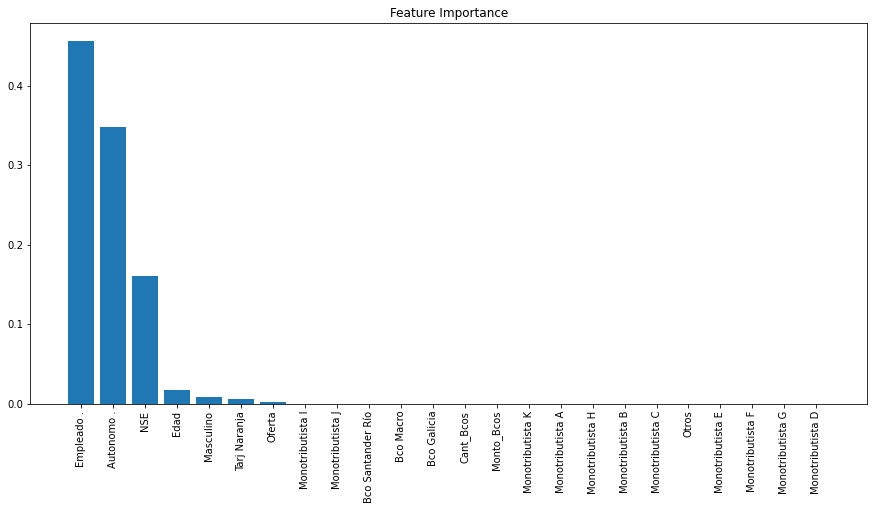

In [242]:
# Graficamos la Importancia de las Features: 

# creamos una variable que tenga los indices indicando los valores de mayor a menor
indices = np.argsort(importances)[::-1]

# con dicha variable realizamos fancy indexing de manera de ordenar los labels del eje x.
names = X.columns[indices]

# Creamos el plot
plt.figure(figsize=(15,7))

# Creamos plot title
plt.title("Feature Importance")

# Agregamos las barras
plt.bar(range(X.shape[1]), importances[indices])

# Agregamos los feature names 
plt.xticks(range(X.shape[1]), names, rotation=90)



# Show plot
plt.show()

# REALIZAMOS PICKLE

In [263]:
# Vamos a serializar con pickle el modelo GradientBoostingClassifier
with open('model_gb.pkl', 'wb') as model:
    pickle.dump(gb_model, model) #Volcamos el contenido de reglog en un archivo llamado reg_model.pkl

In [264]:
# Validamos que se haya generado el archivo 

[x for x in os.listdir() if 'pkl' in x]

['model_gb.pkl']

In [269]:
# Probamos levantar el modelo y lo llamamos con otro nombre
with open('./model_gb.pkl', 'rb') as model_1:
        model_gb = pickle.load(model_1) #Leemos el binario "dumpeado" a disco y lo cargamos en la variable reg_model

In [267]:
#Verificamos el score del modelo serializado
model_gb.score(X_train,y_train)

0.6060648083945823

In [272]:
#Realizamos una prediccion y validamos el resultado entre el modelo serializado y el no serializado
gb_model.predict([[0 for x in range(X_train.shape[1])]])==model_gb.predict([[0 for x in range(X_train.shape[1])]])

array([ True])